<a href="https://colab.research.google.com/github/HarounH/smol/blob/main/rl/hello_rl.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [9]:
# @title Hello RL
# https://chatgpt.com/c/690beda9-a39c-832b-b88b-9d016b9e1179
!pip install "gymnasium[classic-control]"
!pip install "imageio[ffmpeg]"

In [29]:
# @title Q Learning

import gymnasium
import numpy as np
from collections import deque
from dataclasses import dataclass
import io
import base64
import optax

import numpy as np
import imageio.v2 as imageio
from IPython.display import HTML
import jax.numpy as jnp
from flax import struct
import jax

from IPython.display import HTML
import numpy as np
import imageio
import io, base64
from PIL import Image, ImageDraw, ImageFont
import time
from scipy.ndimage.filters import gaussian_filter1d


def show_mp4_from_frames_imageio(
    frames,
    text=None,              # str or list[str]
    text_color=(255, 0, 0), # red
    text_padding=10,
    fps=30,
):
    """
    Display a list of (H, W, 3) RGB frames inline as MP4 with optional per-frame text.

    Args:
        frames: list of frames, each (H, W, 3), RGB.
        fps: frames per second.
        text: either a single string or list of strings (len == len(frames)).
        text_color: RGB tuple for text.
        text_padding: pixels offset from top-right corner.

    Returns:
        IPython.display.HTML object.
    """
    if not frames:
        raise ValueError("frames list is empty")

    # Normalize text argument
    if text is None:
        texts = [None] * len(frames)
    elif isinstance(text, str):
        texts = [text] * len(frames)
    else:
        if len(text) != len(frames):
            raise ValueError("text list must be same length as frames")
        texts = text

    norm_frames = []
    for idx, f in enumerate(frames):
        f = np.asarray(f)

        if f.ndim != 3 or f.shape[-1] != 3:
            raise ValueError(f"Frame must be (H,W,3), got {f.shape}")

        # Normalize dtype → uint8
        if f.dtype != np.uint8:
            if np.issubdtype(f.dtype, np.floating):
                f = np.clip(f, 0.0, 1.0)
                f = (f * 255).astype(np.uint8)
            else:
                f = np.clip(f, 0, 255).astype(np.uint8)

        # Convert to PIL for text overlay
        img = Image.fromarray(f)
        draw = ImageDraw.Draw(img)

        txt = texts[idx]
        if txt:
            # Choose a default font
            try:
                font = ImageFont.truetype("DejaVuSans.ttf", 20)
            except:
                font = ImageFont.load_default()

            # Width via textlength
            tw = draw.textlength(txt, font=font)
            # Height via font metrics
            ascent, descent = font.getmetrics()
            th = ascent + descent
            # Position: top-right
            H, W = f.shape[:2]
            x = W - tw - text_padding
            y = text_padding

            draw.text((x, y), txt, fill=text_color, font=font)

        norm_frames.append(np.asarray(img))

    # Encode MP4 into an in-memory buffer
    buf = io.BytesIO()
    imageio.mimsave(buf, norm_frames, format="mp4", fps=fps)
    buf.seek(0)
    video_bytes = buf.read()

    b64 = base64.b64encode(video_bytes).decode("ascii")

    html = f"""
    <video controls loop>
        <source src="data:video/mp4;base64,{b64}" type="video/mp4">
        Your browser does not support the video tag.
    </video>
    """
    return HTML(html)


/tmp/ipython-input-2525225232.py:24: DeprecationWarning: Please import `gaussian_filter1d` from the `scipy.ndimage` namespace; the `scipy.ndimage.filters` namespace is deprecated and will be removed in SciPy 2.0.0.
  from scipy.ndimage.filters import gaussian_filter1d


In [11]:
def make_env():
    return gymnasium.make("CartPole-v1", render_mode="rgb_array")
env = make_env()
_ = env.reset()
n_steps = 100
frames = []
actions = []
for step_id in range(n_steps):
    frame = env.render()
    frames.append(frame)
    # random_action = env.action_space.sample()
    random_action = 1
    actions.append(f"Action: {random_action}")
    new_state, reward, terminated, truncated, info = env.step(random_action)

    if terminated or truncated:
        break

print(f"{jax.devices()=}")
show_mp4_from_frames_imageio(frames, actions, fps=2)

jax.devices()=[CpuDevice(id=0)]


/usr/lib/python3.12/subprocess.py:1885: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = _fork_exec(


In [12]:
class Memory:
    def __init__(self, max_size: int = 1000):
        self.data = deque(maxlen=max_size)

    def append(self, item):
        self.data.append(item)

    def sample(self, batch_size: int = 4):
        indices = np.random.randint(0, len(self.data), batch_size)
        return [self.data[idx] for idx in indices]

_memory = Memory(4)
[_memory.append(x) for x in [1, 2, 3, 4, 5, 6, 7]]
print(_memory.data)
print(_memory.sample(3))

deque([4, 5, 6, 7], maxlen=4)
[4, 5, 5]


In [13]:
from flax import nnx


class Layer(nnx.Module):
    def __init__(self, dim: int, rngs: nnx.Rngs):
        self.fc1 = nnx.Linear(dim, dim, rngs=rngs)

    def __call__(self, x):
        z = self.fc1(x)
        z = jax.nn.relu(z)
        return z


class QNet(nnx.Module):
    def __init__(self, dim_in: int = 4, d_model: int = 32, num_actions: int = 2, num_layers: int = 2, rngs: nnx.Rngs | None = None):
        self.in_proj = nnx.Linear(dim_in, d_model, rngs=rngs)
        self.out_proj = nnx.Linear(d_model, num_actions, rngs=rngs)
        self.layers = [Layer(d_model, rngs) for _layer_idx in range(num_layers)]

    def __call__(self, x):
        z = self.in_proj(x)
        for layer in self.layers:
            z = layer(z)
        z = self.out_proj(z)
        return z

In [14]:

@struct.dataclass
class Datum:
    s_t: jax.Array
    a_t: jax.Array
    r_t: jax.Array
    s_tp1: jax.Array
    done_t: jax.Array
    is_policy_t: jax.Array = False
    frame_hwc: np.ndarray | None = None

@struct.dataclass
class Batch:
    # TODO: type hint as JAX array likes?
    s_t_BD: jax.Array
    a_t_B: jax.Array
    r_t_B: jax.Array
    s_tp1_BD: jax.Array
    done_t_B: jax.Array
    is_policy_t_B: jax.Array

    @classmethod
    def from_list(cls, datums: list[Datum]) -> "Batch":
        s_t_BD = jnp.stack([d.s_t for d in datums])
        a_t_B = jnp.stack([d.a_t for d in datums])
        r_t_B = jnp.stack([d.r_t for d in datums])
        s_tp1_BD = jnp.stack([d.s_tp1 for d in datums])
        done_t_B = jnp.stack([d.done_t for d in datums])
        is_policy_t_B = jnp.stack([d.is_policy_t for d in datums])

        return Batch(
            s_t_BD=s_t_BD,
            a_t_B=a_t_B,
            r_t_B=r_t_B,
            s_tp1_BD=s_tp1_BD,
            done_t_B=done_t_B,
            is_policy_t_B=is_policy_t_B,
        )

def random_init_memory_bank(memory_bank_size, memory_prefill_episode_count, max_episode_length) -> Memory:
    memory = Memory(memory_bank_size)
    for episode_idx in range(memory_prefill_episode_count):
        current_state, _ = env.reset()
        for step in range(max_episode_length):
            random_action = env.action_space.sample()
            new_state, reward, terminated, truncated, info = env.step(random_action)
            done = terminated or truncated
            memory.append(Datum(s_t=current_state, a_t=random_action, r_t=reward, s_tp1=new_state, done_t=done))
            current_state = new_state
            if done:
                break
    return memory

def random_init_memory_bank_v2(memory_bank_size, memory_prefill_step_count, max_episode_length) -> Memory:
    memory = Memory(memory_bank_size)
    current_state, _ = env.reset()
    for datum in range(memory_prefill_step_count):
        random_action = env.action_space.sample()
        new_state, reward, terminated, truncated, info = env.step(random_action)
        done = terminated or truncated
        memory.append(Datum(s_t=current_state, a_t=random_action, r_t=reward, s_tp1=new_state, done_t=done))
        if done:
            new_state, _ = env.reset()
        current_state = new_state

    return memory

In [19]:
from collections import defaultdict

@struct.dataclass
class DatumPerUpdate:
    update_idx: int
    episode_idx: int
    step_within_episode: int
    loss: float
    running_reward: float
    end_of_episode: bool
    play_time_s: float
    fwd_bwd_time_s: float
    total_time_s: float
    on_policy: bool

class Telemetry:
    def __init__(self):
        self.data_per_update: list[DatumPerUpdate] = []

    def append(self, datum: DatumPerUpdate):
        self.data_per_update.append(datum)

    def metrics_per_episode(self) -> list[dict]:
        data_per_episode = {}
        for datum in self.data_per_update:
            episode = datum.episode_idx
            if episode in data_per_episode:
                d = data_per_episode[episode]
            else:
                d = defaultdict(list)
                data_per_episode[episode] = d

            d["loss"].append(datum.loss)
            d["play_time_s"].append(datum.play_time_s)
            d["fwd_bwd_time_s"].append(datum.fwd_bwd_time_s)
            d["total_time_s"].append(datum.total_time_s)
            d["on_policy"].append(datum.on_policy)
            if datum.end_of_episode:
                d["steps"] = datum.step_within_episode
                d["reward"] = datum.running_reward

        # for each episode
        results = []
        for ep, data in data_per_episode.items():
            while ep >= len(results):
                results.append({})
            results[ep] = {
                "loss": np.mean(data["loss"]),
                "reward": np.mean(data["reward"]),
                "play_time_s": np.mean(data["play_time_s"]),
                "fwd_bwd_time_s": np.mean(data["fwd_bwd_time_s"]),
                "total_time_s": np.mean(data["total_time_s"]),
                "on_policy_pct": np.mean(data["on_policy"]),
            }
        # get average loss
        # average of step length
        # average of total rewards
        return {
            "loss": [x.get("loss") for x in results],
            "reward": [x.get("reward") for x in results],
            "play_time_s": [x.get("play_time_s") for x in results],
            "fwd_bwd_time_s": [x.get("fwd_bwd_time_s") for x in results],
            "total_time_s": [x.get("total_time_s") for x in results],
            "on_policy_pct": [x.get("on_policy_pct") for x in results],
        }

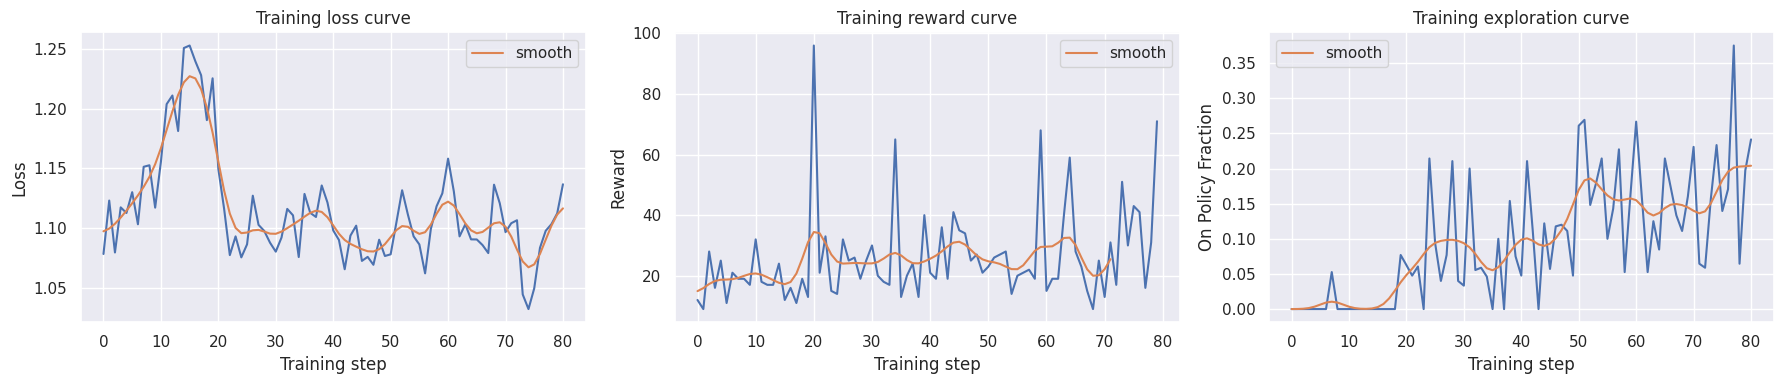

U=2094 | E080 | loss: 1.14 fwd_bwd_time_s: 0.0169s | play_time_s: 0.0037s


/usr/local/lib/python3.12/dist-packages/numpy/_core/fromnumeric.py:3596: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.12/dist-packages/numpy/_core/_methods.py:138: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [ ]:
@dataclass
class Params:
    memory_bank_size: int = 100
    memory_prefill_count: int = 25
    batch_size: int = 24
    num_training_steps: int = 100
    num_training_episodes: int = 100
    max_episode_length: int = 100
    seed: int = 1337

    discount_rate: float = 0.99

    # taken from https://colab.research.google.com/github/udacity/deep-learning/blob/master/reinforcement/Q-learning-cart.ipynb#scrollTo=R2EnJ-hoUyh3
    explore_start = 1.0            # exploration probability at start
    explore_stop = 0.01            # minimum exploration probability
    decay_rate = 0.0001            # exponential decay rate for exploration prob


    d_model: int = 64
    n_layers: int = 3

    lr: float = 1e-3

    ckpt_dir: str = '/tmp/checkpoints/'

params = Params(
    num_training_episodes=1000,
    # num_training_steps=10000,
    max_episode_length=200,
    lr=1e-4,
    discount_rate=0.99,
    d_model=64,
    n_layers=1,

)
rngs = nnx.Rngs(default=params.seed)

num_actions = env.action_space.n
dim_in = env.observation_space.shape[0]

qnet = QNet(dim_in, params.d_model, num_actions, params.n_layers, rngs)
optimizer = nnx.Optimizer(qnet, optax.adamw(params.lr), wrt=nnx.Param)
ckpt_dir = ocp.test_utils.erase_and_create_empty(params.ckpt_dir)
checkpointer = ocp.StandardCheckpointer()
telemetry = Telemetry()

# memory = random_init_memory_bank(params.memory_bank_size, params.memory_prefill_count, params.max_episode_length)
memory = random_init_memory_bank_v2(params.memory_bank_size, params.memory_prefill_count, params.max_episode_length)

def loss_fn(model, s_t_BD, a_t_B, target_qhat_tp1_B, rngs_for_loss):
    qhat_t_BA = qnet(s_t_BD)
    q_t_B = qhat_t_BA.take(a_t_B, axis=0)  # prediction
    return ((q_t_B - target_qhat_tp1_B) ** 2)

batched_loss_fn = jax.vmap(loss_fn, in_axes=(None, 0, 0, 0, None))

@nnx.jit
def train_step(model, optimizer, batch, rngs):
    q_tp1_BA = qnet(batch.s_tp1_BD)
    q_tp1_B = q_tp1_BA.max(axis=1)
    # if batch.done_t_B then q_tp1_B = 0
    q_tp1_B *= (1 - batch.done_t_B)
    # jax.debug.print("{x} {y}", x=batch.done_t_B, y=q_tp1_B)
    # print("Some output", flush=True)
    qhat_tp1_B = batch.r_t_B + params.discount_rate * q_tp1_B  # target

    def closure(model, rngs_for_closure):
        batch_loss = batched_loss_fn(model, batch.s_t_BD, batch.a_t_B, qhat_tp1_B, rngs_for_closure)
        return batch_loss.mean()

    (loss, grads) = nnx.value_and_grad(closure)(model, rngs)

    # return loss, grads
    optimizer.update(grads)
    return loss


def play(model, num_steps, exploration, return_frames, rngs, env, current_state, verbose: bool = False) -> tuple[list[Datum], list[np.ndarray], np.ndarray | None]:
    if env is None:
        env = make_env()
        current_state, _ = env.reset()
    else:
        assert current_state is not None

    trajectory = []

    for step in range(num_steps):
        if return_frames:
            frame = env.render()
        else:
            frame = None
        random_action = env.action_space.sample()
        if model is not None:
            qhat_t_BA = model(current_state)
            action = qhat_t_BA.argmax().item()
            is_policy = True
            if verbose:
                print(f"{current_state=} {qhat_t_BA=} {action=}")
        else:
            action = random_action
            is_policy = False

        if jax.random.bernoulli(rngs.params(), exploration, shape=None):
            is_policy = False
            action = random_action

        new_state, reward, t0, t1, info = env.step(action)
        done = t0 or t1
        datum = Datum(
            s_t=current_state,
            a_t=jnp.asarray(action),
            r_t=jnp.asarray(reward),
            s_tp1=new_state,
            done_t=done,
            is_policy_t=is_policy,
            frame_hwc=frame,
        )
        current_state = new_state
        trajectory.append(datum)

        if done:
            current_state = None
            break

    return trajectory, current_state


from tqdm.notebook import trange
from IPython.display import clear_output
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="darkgrid")



plot_every = 10  # update plot every N steps

pbar = trange(params.num_training_steps, desc="Training", dynamic_ncols=True)
num_updates = 0

episode_end = True
episode_idx = -1
running_losses = []
update_idx = 0

while True:
    update_idx += 1
    if episode_idx == params.num_training_episodes:
        break

    step_start = time.perf_counter()
    # simulation
    ## reset if needed, else do usual update
    if episode_end:
        current_state, _ = env.reset()
        running_reward = 0
        step_within_episode = 0
        episode_idx += 1

    explore_p = params.explore_stop + (params.explore_start - params.explore_stop) * np.exp(-params.decay_rate * update_idx)
    trajectory, current_state = play(
        qnet,
        # what roll out do we want?
        1,
        explore_p,
        return_frames=False,
        rngs=rngs,
        env=env,
        current_state=current_state,
    )
    end_play = time.perf_counter()
    running_reward += trajectory[0].r_t
    step_within_episode += 1
    episode_end = trajectory[0].done_t or (step_within_episode == params.max_episode_length)
    memory.append(trajectory[0])

    # update
    update_start = time.perf_counter()
    batch = Batch.from_list(memory.sample(params.batch_size))
    loss = train_step(qnet, optimizer, batch, rngs)
    running_losses.append(float(loss))
    update_end = time.perf_counter()

    # plot
    plot_start = time.perf_counter()
    if episode_end or update_idx % 50 == 0:
        metrics = telemetry.metrics_per_episode()

        plot_loss = metrics["loss"]
        plot_reward = metrics["reward"]
        plot_play_time_s = metrics["play_time_s"]
        plot_fwd_bwd_time_s = metrics["fwd_bwd_time_s"]
        plot_total_time_s = metrics["total_time_s"]
        plot_on_policy_pct = metrics["on_policy_pct"]

        clear_output(wait=True)

        # keep a bit of textual context
        fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18, 4))
        sns.lineplot(x=range(len(plot_loss)), y=plot_loss, ax=axes[0])
        smooth_loss = gaussian_filter1d(plot_loss, sigma=2)
        sns.lineplot(x=range(len(plot_loss)), y=smooth_loss, ax=axes[0], label="smooth", legend="auto")
        axes[0].set_xlabel("Training step")
        axes[0].set_ylabel("Loss")
        axes[0].set_title("Training loss curve")

        sns.lineplot(x=range(len(plot_reward)), y=plot_reward, ax=axes[1])
        smooth_reward = gaussian_filter1d(plot_reward, sigma=2)
        sns.lineplot(x=range(len(plot_reward)), y=smooth_reward, ax=axes[1], label="smooth", legend="auto")

        axes[1].set_xlabel("Training step")
        axes[1].set_ylabel("Reward")
        axes[1].set_title("Training reward curve")

        sns.lineplot(x=range(len(plot_on_policy_pct)), y=plot_on_policy_pct, ax=axes[2])
        smooth_on_policy = gaussian_filter1d(plot_on_policy_pct, sigma=2)
        sns.lineplot(x=range(len(plot_on_policy_pct)), y=smooth_on_policy, ax=axes[2], label="smooth", legend="auto")
        axes[2].set_xlabel("Training step")
        axes[2].set_ylabel("On Policy Fraction")
        axes[2].set_title("Training exploration curve")

        plt.tight_layout()
        plt.show()
        message = f"U={update_idx:04d} | E{episode_idx:03d} | loss: {np.mean(running_losses):.2f}"
        if len(plot_fwd_bwd_time_s) > 0:
            message += f" fwd_bwd_time_s: {plot_fwd_bwd_time_s[-1]:.4f}s | play_time_s: {plot_play_time_s[-1]:.4f}s"
        print(message)
        running_losses = []
    plot_end = time.perf_counter()
    # log metrics
    telemetry.append(
        DatumPerUpdate(
            update_idx=int(update_idx),
            episode_idx=int(episode_idx),
            step_within_episode=int(step_within_episode),
            loss=float(loss),
            running_reward=float(running_reward),
            end_of_episode=bool(episode_end),
            play_time_s=float(end_play - step_start),
            fwd_bwd_time_s=float(update_end - update_start),
            total_time_s=float(plot_end - step_start),
            on_policy=bool(trajectory[0].is_policy_t),
        )
    )
_, state = nnx.split(qnet)
checkpointer.save(ckpt_dir / 'state', state)

In [ ]:
trajectory, current_state = play(
    qnet,
    # what roll out do we want?
    1000,
    0.0,
    return_frames=True,
    rngs=rngs,
    env=None,
    current_state=None,
    verbose=True
)
print(sum([d.is_policy_t for d in trajectory]) / len(trajectory))
_frames = [d.frame_hwc for d in trajectory]
_texts = [f"action: {d.a_t} step: {i}" for i, d in enumerate(trajectory)]
show_mp4_from_frames_imageio(_frames, _texts, fps=2)